APLICA CAPTUM SOBRE OTRO MODELO ENTRENADO CON EL DATASET TITANIC.

In [84]:
# %pip install torch
# %pip install captum

In [1]:
# Initial imports
import numpy as np

import torch
import torch.nn as nn

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

C:\Users\cpalo\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga del modelo

Como Pytorch guarda las variables del modelo y los pesos y el modelo en su totalidad, hemos cogido la clase definida en el notebook principal.   
Hemos definido una arquitectura simple utilizando 2 capas ocultas, la primera con 12 unidades ocultas y la segunda con 8 unidades ocultas, cada una con no linealidad sigmoide.  La capa final realiza una operación softmax y tiene 2 unidades, correspondientes a las salidas de sobrevivido (1) o no sobrevivido (0).

In [2]:
torch.manual_seed(1)  # Set seed for reproducibility.

class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))
    
    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        elif isinstance(x, torch.Tensor):
            x = x.float()
            
        x = x.view(x.size(0), -1)
        output = self.forward(x)
        predicted_probs = torch.softmax(output, dim=1)
        return predicted_probs
    
    
    def predict_lime(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        elif isinstance(x, torch.Tensor):
            x = x.float()

        x = x.view(x.size(0), -1)
        output = self.forward(x)
        predicted_probs = torch.softmax(output, dim=1)
        _, predicted_labels = torch.max(predicted_probs, 1)
        return predicted_probs.detach().numpy()

## Cargamos los datos del dataset de entrada

In [3]:
# Update path to dataset here.
dataset_path = "../Main Notebook/titanic_data.csv"
# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)

Ahora convertimos los datos en matrices Numpy y separamos los conjuntos de entrenamiento (70%) y prueba (30%).

In [4]:
# Convert features and labels to numpy arrays.
labels = titanic_data["Survived"].to_numpy()
titanic_data = titanic_data.drop(['Survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

Podemos usar un modelo previamente entrenado o entrenar la red usando los datos de entrenamiento para 200 épocas. Se debe tener en cuenta que los resultados de los pasos posteriores pueden no coincidir si se vuelve a entrenar.    En nuestro caso, vamos a cargar y utilizar el modelo ya entrenado

In [5]:
# Creamos una instancia de la clase del modelo.
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    # Cargamos los pesos del modelo guardado en la instancia del modelo.
    net.load_state_dict(torch.load('../Main Notebook/titanic_fcnn.pt'))
    print("Model Loaded!")

    # Convertimos los datos de entrenamiento en tensores.
    input_tensor = torch.from_numpy(train_features).type(torch.BoolTensor)  # Para convertir datos booleanos
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor) # Para convertir datos enteros

    input_tensor = torch.from_numpy(train_features.astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos
    label_tensor = torch.from_numpy(train_labels)
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200

    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

    # input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)

    input_tensor = torch.from_numpy(train_features.astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos
    label_tensor = torch.from_numpy(train_labels)

    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'titanic_model.pt')

Model Loaded!


In [6]:
# Establecemos el modo de evaluacion para el modelo
net.eval()

TitanicSimpleNNModel(
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (sigmoid1): Sigmoid()
  (linear2): Linear(in_features=12, out_features=8, bias=True)
  (sigmoid2): Sigmoid()
  (linear3): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

Ahora podemos evaluar las precisiones de entrenamiento y prueba de nuestro modelo.

In [7]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.826645264847512


In [8]:
test_input_tensor = torch.from_numpy(test_features.astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos

out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.832089552238806


## Implementacion de CAPTUM

Más allá de solo considerar la precisión del clasificador, hay muchas preguntas importantes para comprender cómo funciona el modelo y su decisión, que es el propósito de Captum, ayudar a que las redes neuronales en PyTorch sean más interpretables.

La primera pregunta que podemos hacernos es ¿cuáles de las características fueron realmente importantes para el modelo para llegar a esta decisión? Este es el primer componente principal de Captum, la capacidad de obtener atribuciones de funciones. Para este ejemplo, aplicaremos Integrated Gradients, que es uno de los métodos de Feature Attribution incluidos en Captum. 

Para aplicar gradientes integrados, primero creamos un objeto IntegratedGradients, proporcionando el objeto modelo.

In [9]:
ig = IntegratedGradients(net)

Para calcular los gradientes integrados, usamos el método de atributos del objeto IntegratedGradients. El método toma tensores de ejemplos de entrada (que coinciden con la función de avance del modelo) y devuelve las atribuciones de entrada para los ejemplos dados. Para una red con múltiples salidas, también se debe proporcionar un índice objetivo, definiendo el índice de la salida para el cual se calculan los gradientes. Para este ejemplo, proporcionamos target = 1, correspondiente a la supervivencia.

El tensor de entrada provisto debe requerir grad, por lo que llamamos a require_grad_ en el tensor. El método de atributos también toma una línea de base, que es el punto de partida desde el cual se integran los degradados. El valor predeterminado es solo el tensor 0, que es una línea base/predeterminada razonable para esta tarea.

Los valores devueltos por el método de atributo son las atribuciones, que coinciden con el tamaño de las entradas dadas, y delta, que aproxima el error entre la integral aproximada y la integral verdadera.

Este código realiza una atribución integrada utilizando el método attribute sobre el tensor test_input_tensor, y luego extrae los valores de atribución en forma de un array NumPy para su posterior uso.

In [10]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

Para comprender estas atribuciones, primero podemos promediarlas en todas las entradas e imprimir/visualizar la atribución promedio para cada característica.

Average Feature Importances
Age :  -0.322
SibSp :  -0.114
Parch :  -0.034
Fare :  0.706
female :  0.350
male :  -0.464
Embark_C :  0.031
Embark_Q :  0.008
Embark_S :  -0.088
Class_1 :  0.109
Class_2 :  0.199
Class_3 :  -0.235


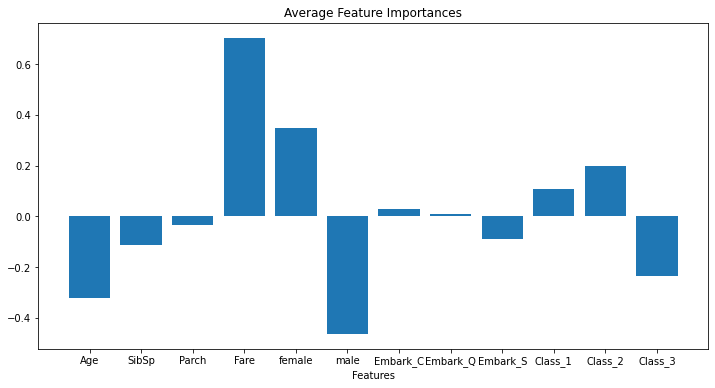

In [11]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

A partir de la información de atribución de características, obtenemos algunas ideas interesantes sobre la importancia de varias características. Vemos que las características más fuertes parecen ser el importe de la tarifa pagada (Fare) y el sexo femenimo, que se correlacionan positivamente con la supervivencia. Por el lado contrario, el sexo masculino y la edad, se correlacionan negativamente con la supervivencia, mientras que embarcarse en Queens y el número de padres/hijos (Parch) parecen ser características menos importantes.

Una cosa importante a tener en cuenta es que las atribuciones promedio sobre el conjunto de prueba no necesariamente capturan toda la información sobre la importancia de las funciones. También deberíamos mirar la distribución de atribuciones para cada función, ya que es posible que las características tengan atribuciones muy diferentes para diferentes ejemplos en el conjunto de datos.

Por ejemplo, podemos visualizar la distribución de atribuciones para el número de hermanos/cónyuges (Sibsp).

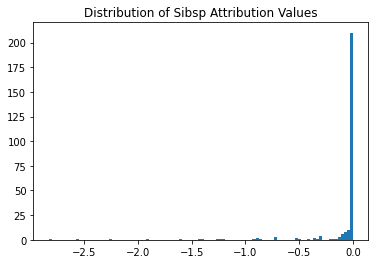

In [13]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

Notamos que la gran mayoría de los ejemplos tienen un valor de atribución de 0 para sibsp, lo que probablemente corresponde a tener un valor de 0 para la función Integrated Gradients (proporcionaría una atribución de 0 cuando el valor de la función coincida con la línea base de 0). Más significativamente, vemos que aunque el promedio parece menor en magnitud en el gráfico anterior, hay una pequeña cantidad de ejemplos con atribuciones negativas para esta característica.

Para comprender mejor esto, podemos agrupar los ejemplos por el valor de la función sibsp y trazar la atribución promedio de la función. En la siguiente gráfica, el tamaño del punto es proporcional al número de ejemplos con ese valor.

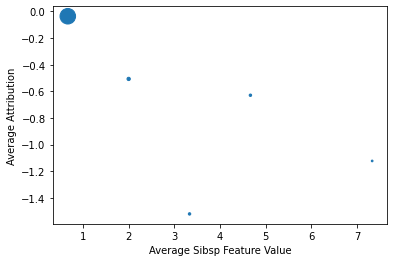

In [14]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

Vemos que las atribuciones de mayor magnitud corresponden a los ejemplos con valores de característica Sibsp más grandes, lo que sugiere que la característica tiene un mayor impacto en la predicción de estos ejemplos. Dado que hay una cantidad sustancialmente menor de estos ejemplos (en comparación con aquellos con un valor de característica de 0), la atribución promedio no captura completamente este efecto.

Ahora que tenemos una mejor comprensión de la importancia de las diferentes características de entrada, la siguiente pregunta que podemos hacer con respecto a la función de la red neuronal es cómo las diferentes neuronas en cada capa trabajan juntas para alcanzar la predicción. Por ejemplo, en nuestra salida de la primera capa oculta que contiene 12 unidades, ¿se usan todas las unidades para la predicción? ¿Algunas unidades aprenden características correlacionadas positivamente con la supervivencia mientras que otras aprenden características correlacionadas negativamente con la supervivencia?

Esto nos lleva al segundo tipo de atribuciones disponibles en Captum, Layer Attributions. Las atribuciones de capa nos permiten comprender la importancia de todas las neuronas en la salida de una capa en particular. Para este ejemplo, usaremos Layer Conductance, uno de los métodos de Layer Attribution en Captum, que es una extensión de Integrated Gradients aplicada a neuronas ocultas. 

Para usar Layer Conductance, creamos un objeto LayerConductance pasando el modelo y el módulo (capa) cuya salida nos gustaría comprender. En este caso, elegimos net.sigmoid1, la salida de la primera capa oculta.

In [15]:
cond = LayerConductance(net, net.sigmoid1)

Ahora podemos obtener los valores de conductancia para todos los ejemplos de prueba llamando al atributo en el objeto LayerConductance. LayerConductance también requiere un índice objetivo para redes con múltiples salidas, definiendo el índice de la salida para el cual se calculan los gradientes. De manera similar a las atribuciones de características, proporcionamos el objetivo = 1, correspondiente a la supervivencia. LayerConductance también utiliza una línea base, pero nosotros simplemente usamos la línea base cero predeterminada como en los degradados integrados.

In [15]:
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

Podemos comenzar visualizando la conductancia promedio para cada neurona.

Average Neuron Importances
0 :  -0.251
1 :  0.017
2 :  0.082
3 :  0.036
4 :  0.217
5 :  0.085
6 :  -0.296
7 :  0.160
8 :  0.047
9 :  0.172
10 :  0.022
11 :  -0.054


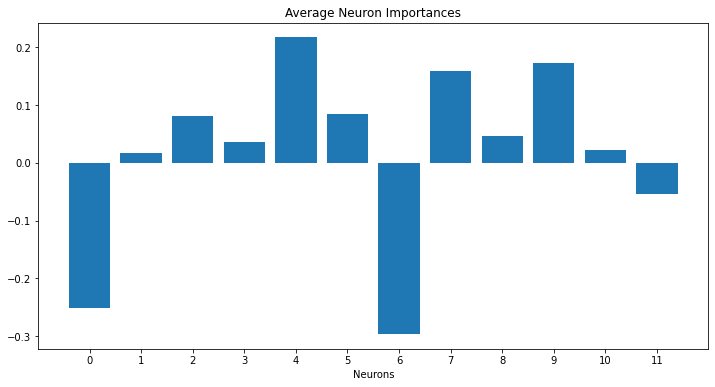

In [16]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

Podemos observar como las neuronas 0 y 6 parecen estar aprendiendo características fuertes negativamente correlacionadas con la supervivencia.

También podemos observar la distribución de las atribuciones de cada neurona. A continuación, observamos las distribuciones de las neuronas 3 y 10, y vemos que la neurona 3, al estar sus distribuciones de atribución muy cercanas a 0, sugiere que no está aprendiendo características sustanciales, mientras que la neurona 10, con una distribución distinta, sí que lo hace.

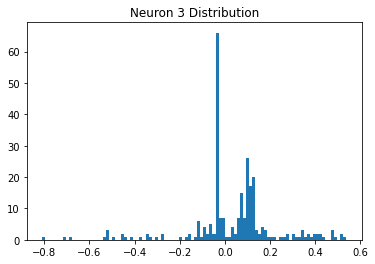

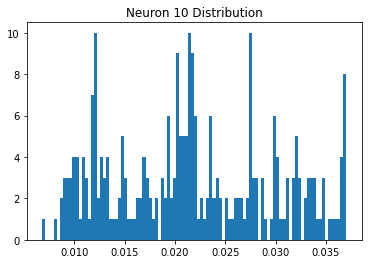

In [27]:
plt.hist(cond_vals[:,3], 100);
plt.title("Neuron 3 Distribution")
plt.figure()
plt.hist(cond_vals[:,10], 100);
plt.title("Neuron 10 Distribution");

Hemos identificado que algunas de las neuronas no están aprendiendo características importantes, mientras que otras sí. ¿Podemos ahora entender qué está mirando cada una de estas importantes neuronas en la entrada? Por ejemplo, ¿identifican características diferentes en la entrada o similares?

Para responder a estas preguntas, podemos aplicar el tercer tipo de atribuciones disponibles en Captum, Neuron Attributions. Esto nos permite comprender qué partes de la entrada contribuyen a activar una neurona de entrada en particular. Para este ejemplo, aplicaremos Neuron Conductance, que divide el valor de conductancia total de la neurona en la contribución de cada característica de entrada individual.

Para usar Neuron Conductance, creamos un objeto NeuronConductance, de manera análoga a Conductance, pasando el modelo y el módulo (capa) cuya salida nos gustaría entender, en este caso, net.sigmoid1, como antes.

In [29]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

Ahora podemos obtener los valores de conductancia de las neuronas para todos los ejemplos de prueba llamando al atributo en el objeto NeuronConductance. Neuron Conductance requiere el índice de neuronas en la capa de destino para la que se solicitan atribuciones, así como el índice de destino para redes con múltiples salidas, similar a la conductancia de capa. Como antes, proporcionamos el objetivo = 1, correspondiente a la supervivencia, y calculamos la conductancia neuronal para las neuronas 0 y 6, las neuronas significativas identificadas anteriormente. El índice de neuronas se puede proporcionar como una tupla o simplemente como un número entero si la salida de la capa es unidimensional.

In [30]:
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_selector=0, target=1)

In [31]:
neuron_cond_vals_6 = neuron_cond.attribute(test_input_tensor, neuron_selector=6, target=1)

Average Feature Importances for Neuron 0
Age :  -0.251
SibSp :  -0.011
Parch :  -0.022
Fare :  0.122
female :  0.142
male :  -0.207
Embark_C :  -0.002
Embark_Q :  -0.001
Embark_S :  0.011
Class_1 :  0.017
Class_2 :  -0.005
Class_3 :  -0.030


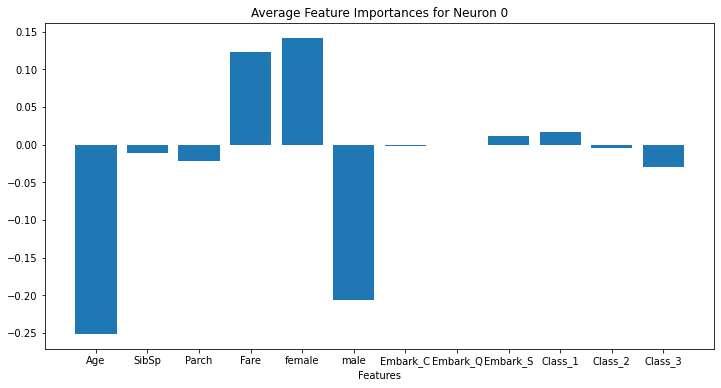

In [32]:
visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")

De los datos anteriores, parece que las funciones de entrada principales utilizadas por la neurona 0 es la edad y el género masculino, con una importancia limitada para todas las demás funciones.

Average Feature Importances for Neuron 6
Age :  -0.293
SibSp :  -0.050
Parch :  0.032
Fare :  -0.093
female :  0.134
male :  -0.083
Embark_C :  0.004
Embark_Q :  -0.000
Embark_S :  0.048
Class_1 :  0.006
Class_2 :  0.092
Class_3 :  -0.069


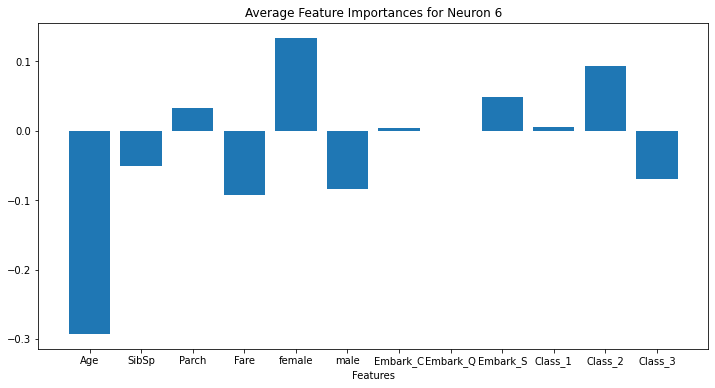

In [33]:
visualize_importances(feature_names, neuron_cond_vals_6.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 6")

De la visualización anterior vemos que la neurona 6 se basa principalmente en la característica de edad, como en la neurona 0, siendo bastante diferente a partir de aquí a la neurona 0.

## Conclusion

En esta demostración, hemos aplicado diferentes técnicas de atribución en Captum, incluidos los gradientes integrados para la atribución de funciones y la conductancia para la atribución de capas y neuronas, a fin de comprender mejor la red neuronal que predice la supervivencia. Aunque las redes más grandes son más difíciles de analizar que esta red simple, estos componentes básicos para la atribución se pueden utilizar para mejorar la interpretabilidad del modelo, rompiendo la caracterización tradicional de "caja negra" de las redes neuronales y profundizando en la comprensión de cómo y por qué hacen su trabajo. decisiones